In [469]:
import os
import sys

from tqdm import tqdm
import numpy as np
import scipy as sp
import pandas as pd
from pykalman import KalmanFilter
import torch
from torch import nn
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.cluster import DBSCAN
import catboost as cb

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from datetime import datetime, timedelta, time

In [470]:
path = "./data/df_hack_final.csv"

In [471]:
df = pd.read_csv(path)
df['MEAS_DT'] = pd.to_datetime(df['MEAS_DT'])

In [472]:
drop_columns = [col for col in df.columns if col[8:11] in ['max', 'min']]
df = df.drop(drop_columns, axis=1)

In [473]:
df.where(df[['Dens_1']] > 1.1, other=np.nan, inplace=True)
df.where(df[['Ni_rec']] != 1, other=np.nan, inplace=True)

In [474]:
def create_step_dataset(df, times_dict, target_list):
    # 6 float
    df_list = []
    total_step = (sum(times_dict.values()) - times_dict[3]) // 15
    df_rec = df[['Ni_rec', 'Ni_resth', 'Cu_resth']][total_step:]
    df_list.append(df_rec)
    # 0
    columns_feed_1 = ['Dens_1', 'Ni_oreth', 'Cu_oreth']
    df_list.append(df[columns_feed_1][:-total_step])
    # 1 
    step_1 = times_dict[1] // 15
    columns_1 = [col for col in df.columns if (col[3] == '1') & (col[4] != 'F')]
    df_list.append(df[columns_1][step_1:-total_step + step_1])
    columns_feed_2 = [col for col in df.columns if (col[3] == '2') & (col[4] == 'F')]
    columns_feed_2.append('Dens_2')
    df_list.append(df[columns_feed_2][step_1:-total_step + step_1])
    # 2
    step_2 = step_1 + times_dict[2] // 15
    columns_2 = [col for col in df.columns if (col[3] == '2') & (col[4] != 'F')]
    df_list.append(df[columns_2][step_2:-total_step + step_2])
    columns_feed_3 = [col for col in df.columns if (col[3] == '3') & (col[4] == 'F')]
    columns_feed_3.append('Dens_3')
    df_list.append(df[columns_feed_3][step_2:-total_step + step_2])
    columns_feed_4 = [col for col in df.columns if (col[3] == '4') & (col[4] == 'F')]
    columns_feed_4.append('Dens_4')
    df_list.append(df[columns_feed_4][step_2:-total_step + step_2])
    # 3
    step_3 = step_2 + times_dict[3] // 15
    columns_3 = [col for col in df.columns if (col[3] == '3') & (col[4] != 'F')]
    df_list.append(df[columns_3][step_3:-total_step + step_3])
    # 4
    step_4 = step_2 + times_dict[4] // 15
    columns_4 = [col for col in df.columns if (col[3] == '4') & (col[4] != 'F')]
    df_list.append(df[columns_4][step_4:-total_step + step_4])
    columns_feed_5 = [col for col in df.columns if (col[3] == '5') & (col[4] == 'F')]
    columns_feed_5.append('Dens_5')
    df_list.append(df[columns_feed_5][step_4:-total_step + step_4])
    # 5
    step_5 = step_4 + times_dict[5] // 15
    columns_5 = [col for col in df.columns if (col[3] == '5') & (col[4] != 'F')]
    df_list.append(df[columns_5][step_5:-total_step + step_5])
    columns_feed_6 = [col for col in df.columns if (col[3] == '6') & (col[4] == 'F')]
    columns_feed_6.append('Dens_6')
    df_list.append(df[columns_feed_6][step_5:-total_step + step_5])
    # 6
    step_6 = step_5 + times_dict[6] // 15
    columns_6 = [col for col in df.columns if (col[3] == '6') & (col[4] != 'F')]
    df_list.append(df[columns_6][step_6:])
    
    full_dataset = pd.concat(df_list, axis=1)
    # full_dataset = full_dataset[~full_dataset[target_list].isna().any(axis=1)]
    full_dataset = full_dataset.reset_index(drop=True)

    return full_dataset.drop(target_list, axis=1), full_dataset[target_list]

In [509]:
# times_dict = {
#     1: 60,
#     2: 60,
#     3: 60,
#     4: 60,
#     5: 60,
#     6: 60
# }

times_dict = {
    1: 60,
    2: 60,
    3: 60,
    4: 45,
    5: 30,
    6: 30,
}

target_list = [
    'Ni_1.1C', 'Cu_1.1C', 'Ni_1.2C', 'Cu_1.2C',
    'Cu_2.1T', 'Cu_2.2T', 
    'Cu_3.1T', 'Cu_3.2T',
    'Ni_4.1C', 'Ni_4.2C',
    'Ni_4.1T', 'Ni_4.2T',
    'Ni_5.1C', 'Ni_5.2C',
    'Ni_5.1T', 'Ni_5.2T',
    'Ni_6.1C', 'Ni_6.2C',
    'Ni_6.1T', 'Ni_6.2T',
]

In [510]:
train_df, target_df = create_step_dataset(df, times_dict, target_list=target_list)

In [511]:
train_df.columns

Index(['Ni_rec', 'Ni_resth', 'Cu_resth', 'Dens_1', 'Ni_oreth', 'Cu_oreth',
       'FM_1.1_A', 'FM_1.2_A', 'Cu_2F', 'Ni_2F', 'Dens_2', 'Cu_2.1C',
       'Ni_2.1C', 'Cu_2.2C', 'Ni_2.2C', 'Ni_2.1T', 'Ni_2.2T', 'FM_2.1_A',
       'FM_2.2_A', 'Cu_3F', 'Ni_3F', 'Dens_3', 'Cu_4F', 'Ni_4F', 'Dens_4',
       'Cu_3.1C', 'Ni_3.1C', 'Cu_3.2C', 'Ni_3.2C', 'Ni_3.1T', 'Ni_3.2T',
       'FM_3.1_A', 'FM_3.2_A', 'FM_4.1_A', 'FM_4.2_A', 'Ni_5F', 'Dens_5',
       'FM_5.1_A', 'FM_5.2_A', 'Ni_6F', 'Dens_6', 'FM_6.1_A', 'FM_6.2_A'],
      dtype='object')

In [512]:
model = cb.CatBoostRegressor(
    iterations=2000,
    learning_rate=0.02,
    depth=6,
    loss_function='MultiRMSEWithMissingValues',
    eval_metric='MultiRMSEWithMissingValues'
)

In [513]:
model.fit(train_df, target_df, verbose=False)

In [525]:
predictions = model.predict(train_df)
rmse = ((target_df - predictions) ** 2).mean(axis=0) ** 0.5
rmse

Ni_1.1C    0.161159
Cu_1.1C    0.106635
Ni_1.2C    0.136895
Cu_1.2C    0.182143
Cu_2.1T    0.018645
Cu_2.2T    0.018594
Cu_3.1T    0.353590
Cu_3.2T    0.207608
Ni_4.1C    0.103629
Ni_4.2C    0.097167
Ni_4.1T    0.021086
Ni_4.2T    0.039744
Ni_5.1C    0.116877
Ni_5.2C    0.200646
Ni_5.1T    0.025854
Ni_5.2T    0.027084
Ni_6.1C    0.109308
Ni_6.2C    0.072542
Ni_6.1T    0.049855
Ni_6.2T    0.085666
dtype: float64

In [519]:
model.save_model("./models/step_model_01.h5")

In [214]:
def apply_kalman_filter_to_column(column):
    # Параметры модели фильтра Калмана
    initial_state_mean = column.iloc[0]
    observation_covariance = np.eye(1)
    transition_covariance = np.eye(1)
    transition_matrix = np.array([[1]])
    
    kf = KalmanFilter(
        transition_matrices=transition_matrix,
        observation_matrices=np.ones((1, 1)),
        initial_state_mean=initial_state_mean,
        initial_state_covariance=observation_covariance,
        observation_covariance=observation_covariance,
        transition_covariance=transition_covariance
    )
    
    state_means, _ = kf.filter(column.values)
    
    # Вставляем отфильтрованные значения обратно в исходную колонку
    filtered_col = column.copy()
    filtered_col.loc[column.index] = state_means.flatten()
    
    return filtered_col

In [215]:
df_kalman = df.copy()

for col in df.select_dtypes(include=[np.number]):
    df_kalman[col] = apply_kalman_filter_to_column(df_kalman[col])

### Inference

In [531]:
model = cb.CatBoostRegressor().load_model("./models/step_model_01.h5")

In [532]:
train_df['Ni_resth'] = 9.

In [533]:
predictions = model.predict(train_df)

In [534]:
predictions_df = pd.DataFrame(predictions, columns=target_df.columns)
predictions_df['MEAS_DT'] = df['MEAS_DT']

In [535]:
test_path = "./data/test.csv"

In [536]:
test_df = pd.read_csv(test_path)
test_df = test_df.infer_objects()
test_df['MEAS_DT'] = pd.to_datetime(test_df['MEAS_DT'])

In [547]:
def get_threshold(col_name):
    threshold_dict = {
        'Ni_1.*C': 0.1,
        'Cu_1.*C': 0.1,
        'Cu_2.*T': 0.01,
        'Cu_3.*T': 0.05,
        'Ni_4.*T': 0.01,
        'Ni_4.*C': 0.05,
        'Ni_5.*T': 0.01,
        'Ni_5.*C': 0.05,
        'Ni_6.*T': 0.01,
        'Ni_6.*C': 0.05,
    }
    col_name = list(col_name)
    col_name[5] = '*'
    col_name = ''.join(col_name)
    return threshold_dict[col_name]


def create_test_df(test_df, predictions_df, rmse, window_size=8):
    full_df = test_df.merge(predictions_df, on='MEAS_DT')
    for col in predictions_df.columns:
        if col == 'MEAS_DT':
            continue
        cur_threshold = get_threshold(col)
        # print(cur_threshold)
        data = full_df[col]
        err = rmse[col]
        cur_min = data[:window_size].min()
        cur_max = data[:window_size].max()

        splitter = DecisionTreeRegressor(min_samples_leaf=window_size).fit(np.arange(data.shape[0]).reshape(-1, 1), data.to_numpy().reshape(-1, 1))
        predict = splitter.predict(np.arange(data.shape[0]).reshape(-1, 1))

        cur_predict = predict[0] // cur_threshold * cur_threshold
        min_arr = np.zeros_like(data)
        max_arr = np.zeros_like(data)
        cur_gap = ((data[:window_size].std() + 2 * err) // cur_threshold + 1) * cur_threshold 
        for i, num in enumerate(predict):
            if abs(num - cur_predict) < cur_threshold:
                predict[i] = cur_predict
            else:
                cur_predict = predict[i] // cur_threshold * cur_threshold
                predict[i] = cur_predict
                cur_gap = ((data[i:i + window_size].std() + 2 * err) // cur_threshold + 1) * cur_threshold 
            min_arr[i] = predict[i] - cur_gap
            max_arr[i] = predict[i] + cur_gap
        full_df[f'{col}_min'] = min_arr
        full_df[f'{col}_max'] = max_arr
    return full_df.loc[:, test_df.columns], full_df

In [548]:
result_df, full_df = create_test_df(test_df, predictions_df, rmse, window_size=8)

In [549]:
result_df

,MEAS_DT,Ni_1.1C_min,Ni_1.1C_max,Cu_1.1C_min,Cu_1.1C_max,Ni_1.2C_min,Ni_1.2C_max,Cu_1.2C_min,Cu_1.2C_max,Cu_2.1T_min,...,Ni_5.2C_min,Ni_5.2C_max,Ni_6.1T_min,Ni_6.1T_max,Ni_6.1C_min,Ni_6.1C_max,Ni_6.2T_min,Ni_6.2T_max,Ni_6.2C_min,Ni_6.2C_max
0,2024-01-19 12:15:00,2.3,3.1,4.2,5.0,2.5,3.3,4.4,5.2,0.39,...,5.95,6.95,1.02,1.28,8.4,9.2,0.78,1.24,8.85,9.35
1,2024-01-19 12:30:00,2.3,3.1,4.2,5.0,2.5,3.3,4.4,5.2,0.39,...,5.95,6.95,1.02,1.28,8.4,9.2,0.78,1.24,8.85,9.35
2,2024-01-19 12:45:00,2.3,3.1,4.2,5.0,2.5,3.3,4.4,5.2,0.39,...,5.95,6.95,1.02,1.28,8.4,9.2,0.78,1.24,8.85,9.35
3,2024-01-19 13:00:00,2.3,3.1,4.2,5.0,2.5,3.3,4.4,5.2,0.39,...,5.95,6.95,1.02,1.28,8.4,9.2,0.78,1.24,8.85,9.35
4,2024-01-19 13:15:00,2.3,3.1,4.2,5.0,2.5,3.3,4.4,5.2,0.39,...,5.95,6.95,1.02,1.28,8.4,9.2,0.78,1.24,8.85,9.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6735,2024-11-05 17:30:00,2.4,3.2,4.2,4.8,2.7,3.3,4.0,5.0,0.33,...,6.00,6.90,1.51,1.83,8.6,9.3,1.25,1.73,8.85,9.35
6736,2024-11-05 17:45:00,2.4,3.2,4.2,4.8,2.7,3.3,4.0,5.0,0.33,...,6.00,6.90,1.51,1.83,8.6,9.3,1.25,1.73,8.85,9.35
6737,2024-11-05 18:00:00,2.4,3.2,4.2,4.8,2.7,3.3,4.0,5.0,0.33,...,6.00,6.90,1.51,1.83,8.6,9.3,1.25,1.73,8.85,9.35
6738,2024-11-05 18:15:00,2.4,3.2,4.2,4.8,2.7,3.3,4.0,5.0,0.33,...,6.00,6.90,1.51,1.83,8.6,9.3,1.25,1.73,8.85,9.35


In [550]:
result_df.to_csv("./test_results/test.csv", index=False)

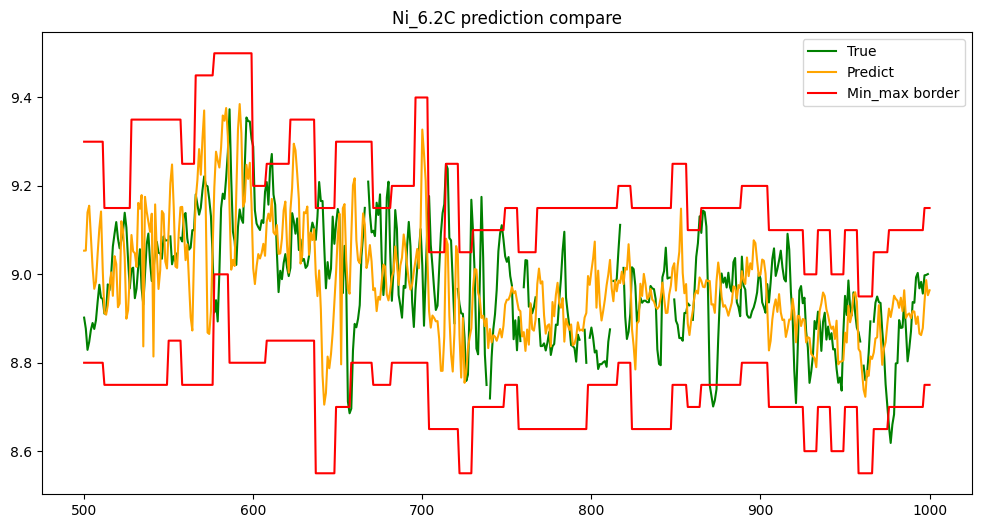

In [558]:
col = "Ni_6.2C"

plt.figure(figsize=(12, 6))
plt.plot(full_df.merge(df, on='MEAS_DT')[f"{col}_y"][500:1000], c="green", label="True")
plt.plot(full_df.loc[500:1000, f"{col}"], c="orange", label="Predict")
plt.plot(result_df.loc[500:1000, f"{col}_min"], c="red", label="Min_max border")
plt.plot(result_df.loc[500:1000, f"{col}_max"], c="red")
plt.title(f"{col} prediction compare")
plt.legend()